In [1]:
%matplotlib inline

import pandas as pd
import nivapy3 as nivapy
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

# Patching missing data in Martini river inputs

[Notebook 1](https://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/01_data_pre-processing.ipynb) and [notebook 2](https://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/02_riverine_inputs.ipynb) generated daily time series of river concentrations based on available monitoring data. Results are summaries in the Excel file [here](https://github.com/JamesSample/martini/blob/master/data/tidy/martini_daily_conc_q_summary.xlsx).

There are significant gaps in the dataset for some sites and variables. This notebook attempts to patch missing data using national aggregated values, where appropriate.

In [2]:
# Read station metadata
xl_path = r'../data/tidy/martini_daily_conc_q_summary.xlsx'
stn_df = pd.read_excel(xl_path, sheet_name='stations')
stn_df.head()

station_id andre_id                         station_name  country  \
0          NaN  dmca003                           Vigsø bukt  Denmark   
1  oda_4000005  dmca004  West side of Nord-Jylland - Liver Å  Denmark   
2  oda_3000002  dmca005         Hirtshals-Skagen - Uggerby Å  Denmark   
3          NaN  dmca006               Skagen- Lyngsaa strand  Denmark   
4          NaN  dmca007            East side of Nord-Jylland  Denmark   

     missing_vars             status comment  
0             All  No data available     NaN  
1  TOC, DOC, SiO2                NaN     NaN  
2  TOC, DOC, SiO2                NaN     NaN  
3             All  No data available     NaN  
4             All  No data available     NaN

In [3]:
# Read conc. data
xl_path = r'../data/tidy/martini_daily_conc_q_summary.xlsx'
df = pd.read_excel(xl_path, sheet_name='daily_q_concs')
df.head()

station_id sample_date  flow_m3/s   DOC_mg/l   TOC_mg/l  N-NH4_µg/l  \
0  mvm_00031  2015-01-01       8.16  12.015229  12.357686   39.661330   
1  mvm_00031  2015-01-02      14.50  12.285986  12.636160   37.956995   
2  mvm_00031  2015-01-03      12.60  12.219281  12.567554   38.366488   
3  mvm_00031  2015-01-04       9.89  12.105115  12.450133   39.082954   
4  mvm_00031  2015-01-05       8.18  12.016369  12.358859   39.653913   

   N-SNOX_µg/l    TON_µg/l    DON_µg/l   PON_µg/l  N-TOT_µg/l  SRP_µg/l  \
0   396.930968  370.056356  306.720481  63.335874  806.648654       NaN   
1   466.537849  338.265235  280.370473  57.894761  842.760079       NaN   
2   448.480497  346.944379  287.564165  59.380214  833.791364       NaN   
3   418.971385  360.496398  298.796729  61.699669  818.550738       NaN   
4   397.204152  369.941025  306.624889  63.316135  806.799090       NaN   

    TIP_µg/l   TOP_µg/l  DOP_µg/l   POP_µg/l  P-TOT_µg/l    SIO2_µg/l  \
0  13.955622  21.385048  6.252994  15.132054   35.340670  2759.452655   
1  15.552948  20.041700  5.860198  14.181502   35.594649  3153.424089   
2  15.146590  20.385842  5.960826  14.425016   35.532432  3052.267707   
3  14.470710  20.954702  6.127160  14.827541   35.425412  2885.411774   
4  13.962063  21.379684  6.251425  15.128259   35.341747  2761.021206   

   STS_mg/l  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

In [4]:
# Merge SRP and TIP columns to TIP
# Denmark reports SRP, others report TIP. We're assuming these are the same
df['TIP_µg/l'] = df['TIP_µg/l'].where(df['TIP_µg/l'].notnull(), df['SRP_µg/l'])
del df['SRP_µg/l']

In [5]:
# Melt to long format for later
df_long = df.melt(id_vars=['station_id', 'sample_date'])
df_long.head()

station_id sample_date   variable  value
0  mvm_00031  2015-01-01  flow_m3/s   8.16
1  mvm_00031  2015-01-02  flow_m3/s  14.50
2  mvm_00031  2015-01-03  flow_m3/s  12.60
3  mvm_00031  2015-01-04  flow_m3/s   9.89
4  mvm_00031  2015-01-05  flow_m3/s   8.18

In [6]:
# Dict for storing national median time series
patch_dict = {}

## 1. Denmark

All Danish stations are missing TOC, DOC and SiO2. There are 9 stations in Denmark with complete datasets for the other variables.

In [7]:
# Danish stations with data
den_stn_df = stn_df.query('country == "Denmark"').dropna(subset=['station_id'])
den_stn_df

station_id andre_id                         station_name  country  \
1    oda_4000005  dmca004  West side of Nord-Jylland - Liver Å  Denmark   
2    oda_3000002  dmca005         Hirtshals-Skagen - Uggerby Å  Denmark   
6   oda_15000002  dmca009                          Kastbjerg A  Denmark   
7   oda_15000035  dmca009                         Villestrup A  Denmark   
8   oda_21000409  dmca010                             Alling A  Denmark   
10  oda_15000032      NaN                        Haslevgårds A  Denmark   
11   oda_2000005      NaN                             Elling A  Denmark   
12   oda_5000003      NaN                               Voer A  Denmark   
13   oda_8000001      NaN                                 Gerå  Denmark   

      missing_vars status                                            comment  
1   TOC, DOC, SiO2    NaN                                                NaN  
2   TOC, DOC, SiO2    NaN                                                NaN  
6   TOC, DOC, SiO2    NaN  One of several tributaries upstream of dmca009...  
7   TOC, DOC, SiO2    NaN  One of several tributaries upstream of dmca009...  
8   TOC, DOC, SiO2    NaN  Tributary upstream of dmca010 (Gudenå). Flows ...  
10  TOC, DOC, SiO2    NaN  River on E coast just N of Mariagerfjord. Not ...  
11  TOC, DOC, SiO2    NaN  River on E coast just N of Frederikshavn. Not ...  
12  TOC, DOC, SiO2    NaN  River on E coast mid-way between Frederikshavn...  
13  TOC, DOC, SiO2    NaN  River on E coast just N of Limfjorden. Not cur...

In [8]:
# Get chem for Danish stations
stn_list = list(den_stn_df['station_id'].unique())
den_df = df.query('station_id in @stn_list').copy()

# Drop flow, TOC, DOC and SiO2
den_df.drop(['flow_m3/s', 'DOC_mg/l', 'TOC_mg/l', 'SIO2_µg/l'], 
            inplace=True, 
            axis='columns')

den_df = den_df.melt(id_vars=['station_id', 'sample_date'])

den_df.head()

station_id sample_date    variable       value
0  oda_15000002  2015-01-01  N-NH4_µg/l   76.571577
1  oda_15000002  2015-01-02  N-NH4_µg/l   94.469396
2  oda_15000002  2015-01-03  N-NH4_µg/l  103.288366
3  oda_15000002  2015-01-04  N-NH4_µg/l   85.020159
4  oda_15000002  2015-01-05  N-NH4_µg/l  110.911972

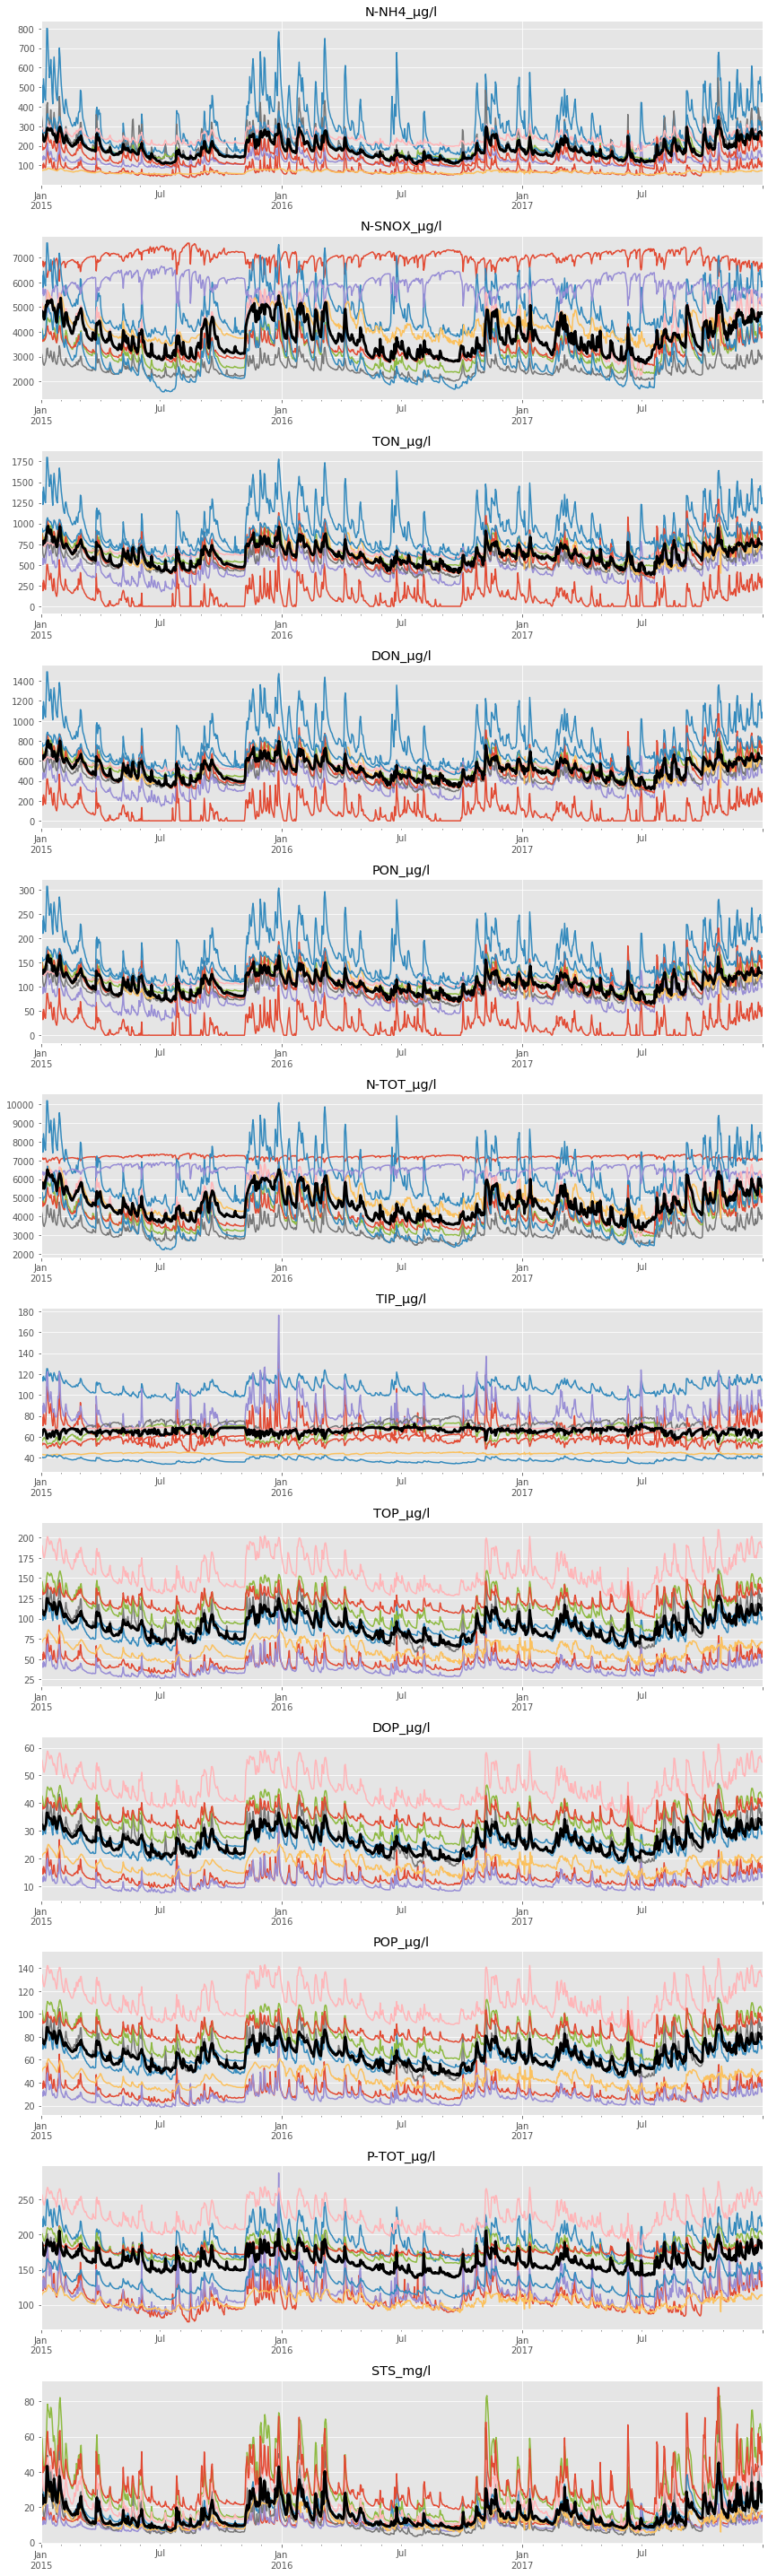

In [9]:
# Plot range of values for each variable
fig, axes = plt.subplots(nrows=len(den_df['variable'].unique()), ncols=1, figsize=(12,40))

# Loop over Danish data
for idx, var_name in enumerate(den_df['variable'].unique()):
    # Get data
    var_df = den_df.query('variable == @var_name')
    
    # Loop over stations
    df_list = []
    for stn_id in var_df['station_id'].unique():
        # Get data for stn
        stn_var_df = var_df.query('station_id == @stn_id')
        stn_var_df = stn_var_df[['sample_date', 'value']]
        stn_var_df.set_index('sample_date', inplace=True)
        df_list.append(stn_var_df)
        stn_var_df.plot(ax=axes[idx], legend=False)
    
    # Get median over all stations for this variable
    agg_df = pd.concat(df_list, axis='columns')
    med_df = agg_df.median(axis='columns')
    patch_dict[('Denmark', var_name)] = med_df
    
    # Plot
    med_df.plot(ax=axes[idx], legend=False, lw=3, c='k')
    axes[idx].set_title(var_name)
    axes[idx].set_xlabel('')
    
plt.tight_layout()

In [10]:
# For consitency, adjust values for TON, N-TOT, TOP and P-TOT so that totals make sense
patch_dict[('Denmark', 'TON_µg/l')] = (patch_dict[('Denmark', 'DON_µg/l')] + 
                                       patch_dict[('Denmark', 'PON_µg/l')]) 

patch_dict[('Denmark', 'N-TOT_µg/l')] = (patch_dict[('Denmark', 'TON_µg/l')] + 
                                         patch_dict[('Denmark', 'N-NH4_µg/l')] + 
                                         patch_dict[('Denmark', 'N-SNOX_µg/l')])

patch_dict[('Denmark', 'TOP_µg/l')] = (patch_dict[('Denmark', 'DOP_µg/l')] + 
                                       patch_dict[('Denmark', 'POP_µg/l')])

patch_dict[('Denmark', 'P-TOT_µg/l')] = (patch_dict[('Denmark', 'TOP_µg/l')] + 
                                         patch_dict[('Denmark', 'TIP_µg/l')])

## 2. Norway

In [11]:
# Norway stations with complete data
nor_stn_df = stn_df.query('country == "Norway"').query('status == "OK"')
nor_stn_df

station_id andre_id        station_name country missing_vars status  \
14     vm_001  nmca001    Haldenvassdraget  Norway          NaN     OK   
15     vm_002  nmca002              Glomma  Norway          NaN     OK   
25     vm_012  nmca012        Drammenselva  Norway          NaN     OK   
28     vm_015  nmca015       Numedalslågen  Norway          NaN     OK   
29     vm_016  nmca016    Skiensvassdraget  Norway          NaN     OK   
30     vm_017  nmca017   Kragerøvassdraget  Norway          NaN     OK   
32     vm_019  nmca019  Arendalsvassdraget  Norway          NaN     OK   
33     vm_020  nmca020   Tovdalsvassdraget  Norway          NaN     OK   
34     vm_021  nmca021                Otra  Norway          NaN     OK   
35     vm_022  nmca022         Mandalselva  Norway          NaN     OK   
37     vm_024  nmca024               Lygna  Norway          NaN     OK   
38     vm_025  nmca025               Kvina  Norway          NaN     OK   

                                              comment  
14                                                NaN  
15  Flows and concentrations are given upstream of...  
25                                                NaN  
28                                                NaN  
29                                                NaN  
30                                                NaN  
32                                                NaN  
33                                                NaN  
34                                                NaN  
35                                                NaN  
37                                                NaN  
38                                                NaN

In [12]:
# Get chem for Norwegian stations
stn_list = list(nor_stn_df['station_id'].unique())
nor_df = df.query('station_id in @stn_list').copy()

# Drop flow
nor_df.drop(['flow_m3/s'], 
            inplace=True, 
            axis='columns')

nor_df = nor_df.melt(id_vars=['station_id', 'sample_date'])

nor_df.head()

station_id sample_date  variable     value
0     vm_001  2015-01-01  DOC_mg/l  8.247817
1     vm_001  2015-01-02  DOC_mg/l  8.319017
2     vm_001  2015-01-03  DOC_mg/l  8.313496
3     vm_001  2015-01-04  DOC_mg/l  8.282252
4     vm_001  2015-01-05  DOC_mg/l  8.276060

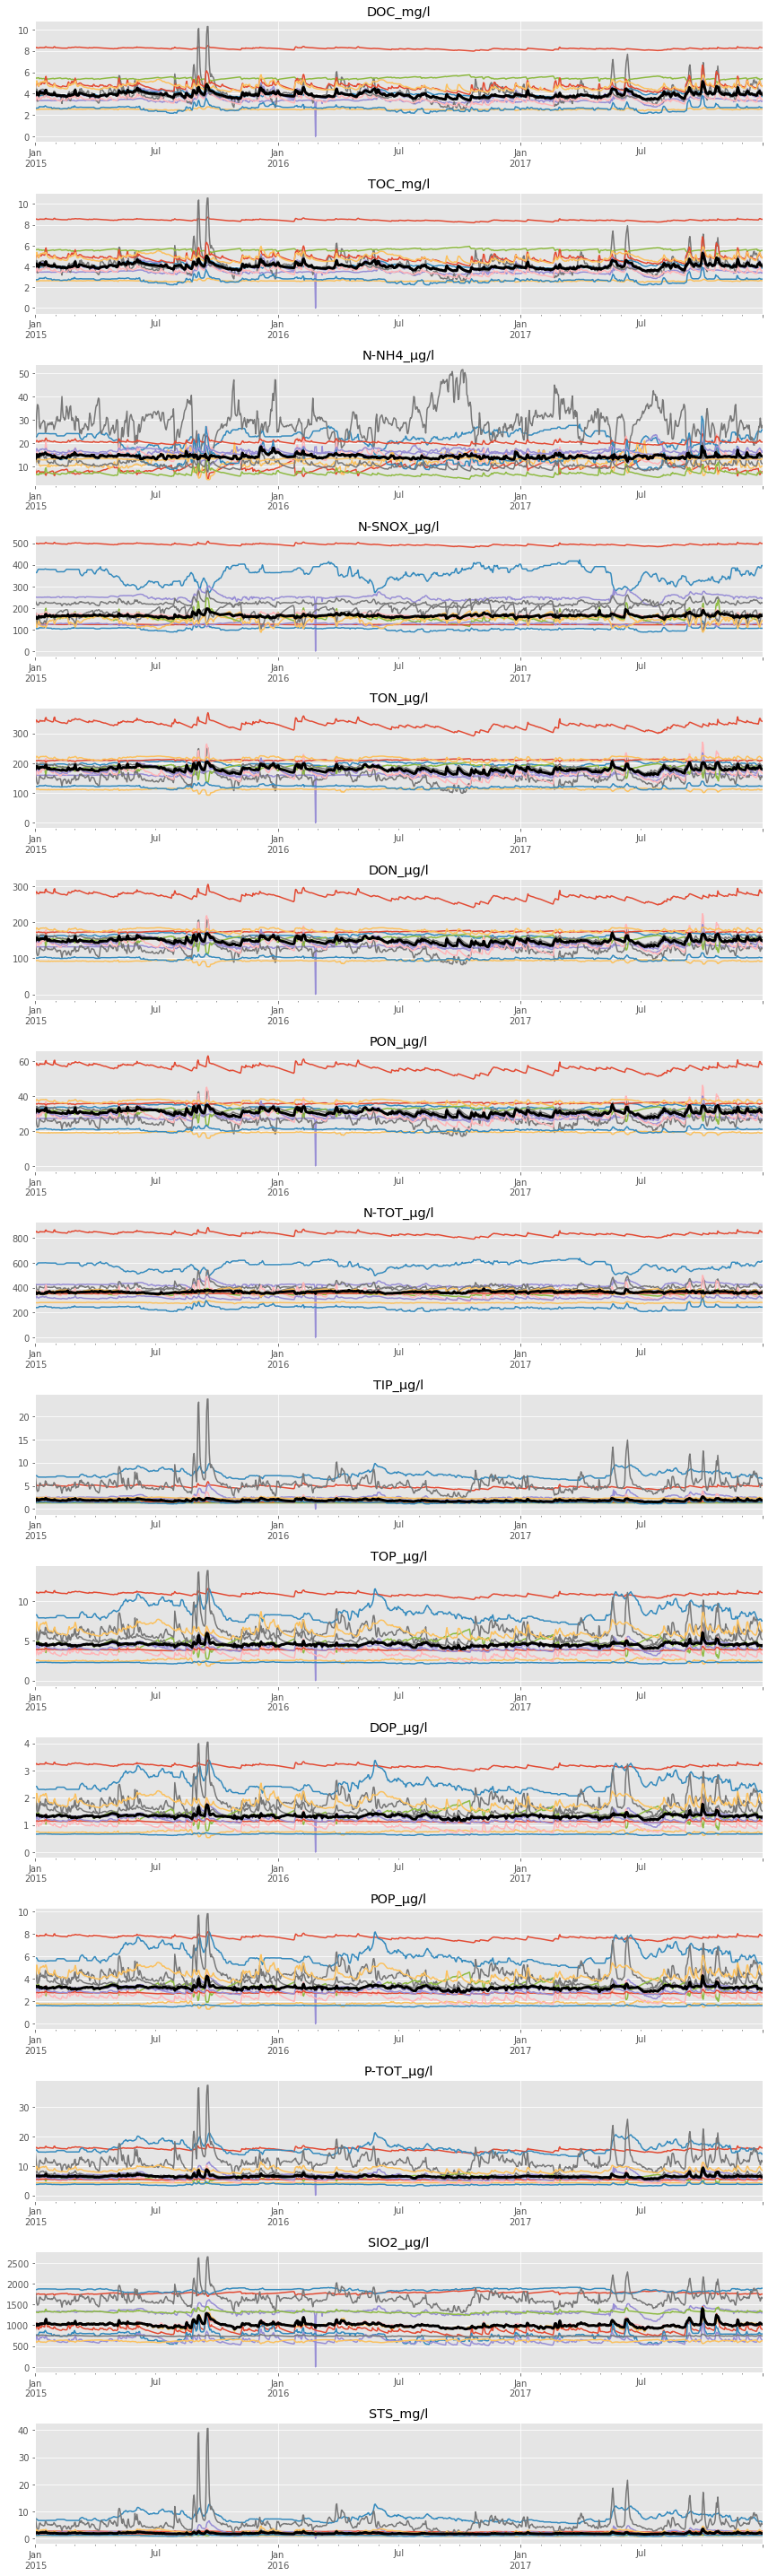

In [13]:
# Plot range of values for each variable
fig, axes = plt.subplots(nrows=len(nor_df['variable'].unique()), ncols=1, figsize=(12,40))

# Loop over Danish data
for idx, var_name in enumerate(nor_df['variable'].unique()):
    # Get data
    var_df = nor_df.query('variable == @var_name')
    
    # Loop over stations
    df_list = []
    for stn_id in var_df['station_id'].unique():
        # Get data for stn
        stn_var_df = var_df.query('station_id == @stn_id')
        stn_var_df = stn_var_df[['sample_date', 'value']]
        stn_var_df.set_index('sample_date', inplace=True)
        df_list.append(stn_var_df)
        stn_var_df.plot(ax=axes[idx], legend=False)
    
    # Get median over all stations for this variable
    agg_df = pd.concat(df_list, axis='columns')
    med_df = agg_df.median(axis='columns')
    patch_dict[('Norway', var_name)] = med_df
    
    # Plot
    med_df.plot(ax=axes[idx], legend=False, lw=3, c='k')
    axes[idx].set_title(var_name)
    axes[idx].set_xlabel('')
    
plt.tight_layout()

In [14]:
# For consitency, adjust values for TON, N-TOT, TOP and P-TOT so that totals make sense
patch_dict[('Norway', 'TON_µg/l')] = (patch_dict[('Norway', 'DON_µg/l')] + 
                                       patch_dict[('Norway', 'PON_µg/l')]) 

patch_dict[('Norway', 'N-TOT_µg/l')] = (patch_dict[('Norway', 'TON_µg/l')] + 
                                         patch_dict[('Norway', 'N-NH4_µg/l')] + 
                                         patch_dict[('Norway', 'N-SNOX_µg/l')])

patch_dict[('Norway', 'TOP_µg/l')] = (patch_dict[('Norway', 'DOP_µg/l')] + 
                                       patch_dict[('Norway', 'POP_µg/l')])

patch_dict[('Norway', 'P-TOT_µg/l')] = (patch_dict[('Norway', 'TOP_µg/l')] + 
                                         patch_dict[('Norway', 'TIP_µg/l')])

## 3. Sweden

In [15]:
# Sweden stations with near-complete data
swe_stn_df = stn_df.query('country == "Sweden"').query('status == "OK"')
swe_stn_df

station_id andre_id     station_name country missing_vars status  \
39  mvm_00043_n  smca108   Göta Älv North  Sweden          STS     OK   
40  mvm_00043_s  smca108   Göta Älv South  Sweden          STS     OK   
41    mvm_00031  smca109           Bäveån  Sweden          STS     OK   
42    mvm_00032  smca110     Örekilsälven  Sweden          STS     OK   
44    mvm_00035  smca112  Enningdalsälven  Sweden          STS     OK   

                                              comment  
39  Chemistry concentrations for both branches of ...  
40  Chemistry concentrations for both branches of ...  
41                                                NaN  
42                                                NaN  
44                                                NaN

In [16]:
# Get chem for Swedish stations
stn_list = list(swe_stn_df['station_id'].unique())
swe_df = df.query('station_id in @stn_list').copy()

# Drop flow and STS
swe_df.drop(['flow_m3/s', 'STS_mg/l'], 
            inplace=True, 
            axis='columns')

swe_df = swe_df.melt(id_vars=['station_id', 'sample_date'])

swe_df.head()

station_id sample_date  variable      value
0  mvm_00031  2015-01-01  DOC_mg/l  12.015229
1  mvm_00031  2015-01-02  DOC_mg/l  12.285986
2  mvm_00031  2015-01-03  DOC_mg/l  12.219281
3  mvm_00031  2015-01-04  DOC_mg/l  12.105115
4  mvm_00031  2015-01-05  DOC_mg/l  12.016369

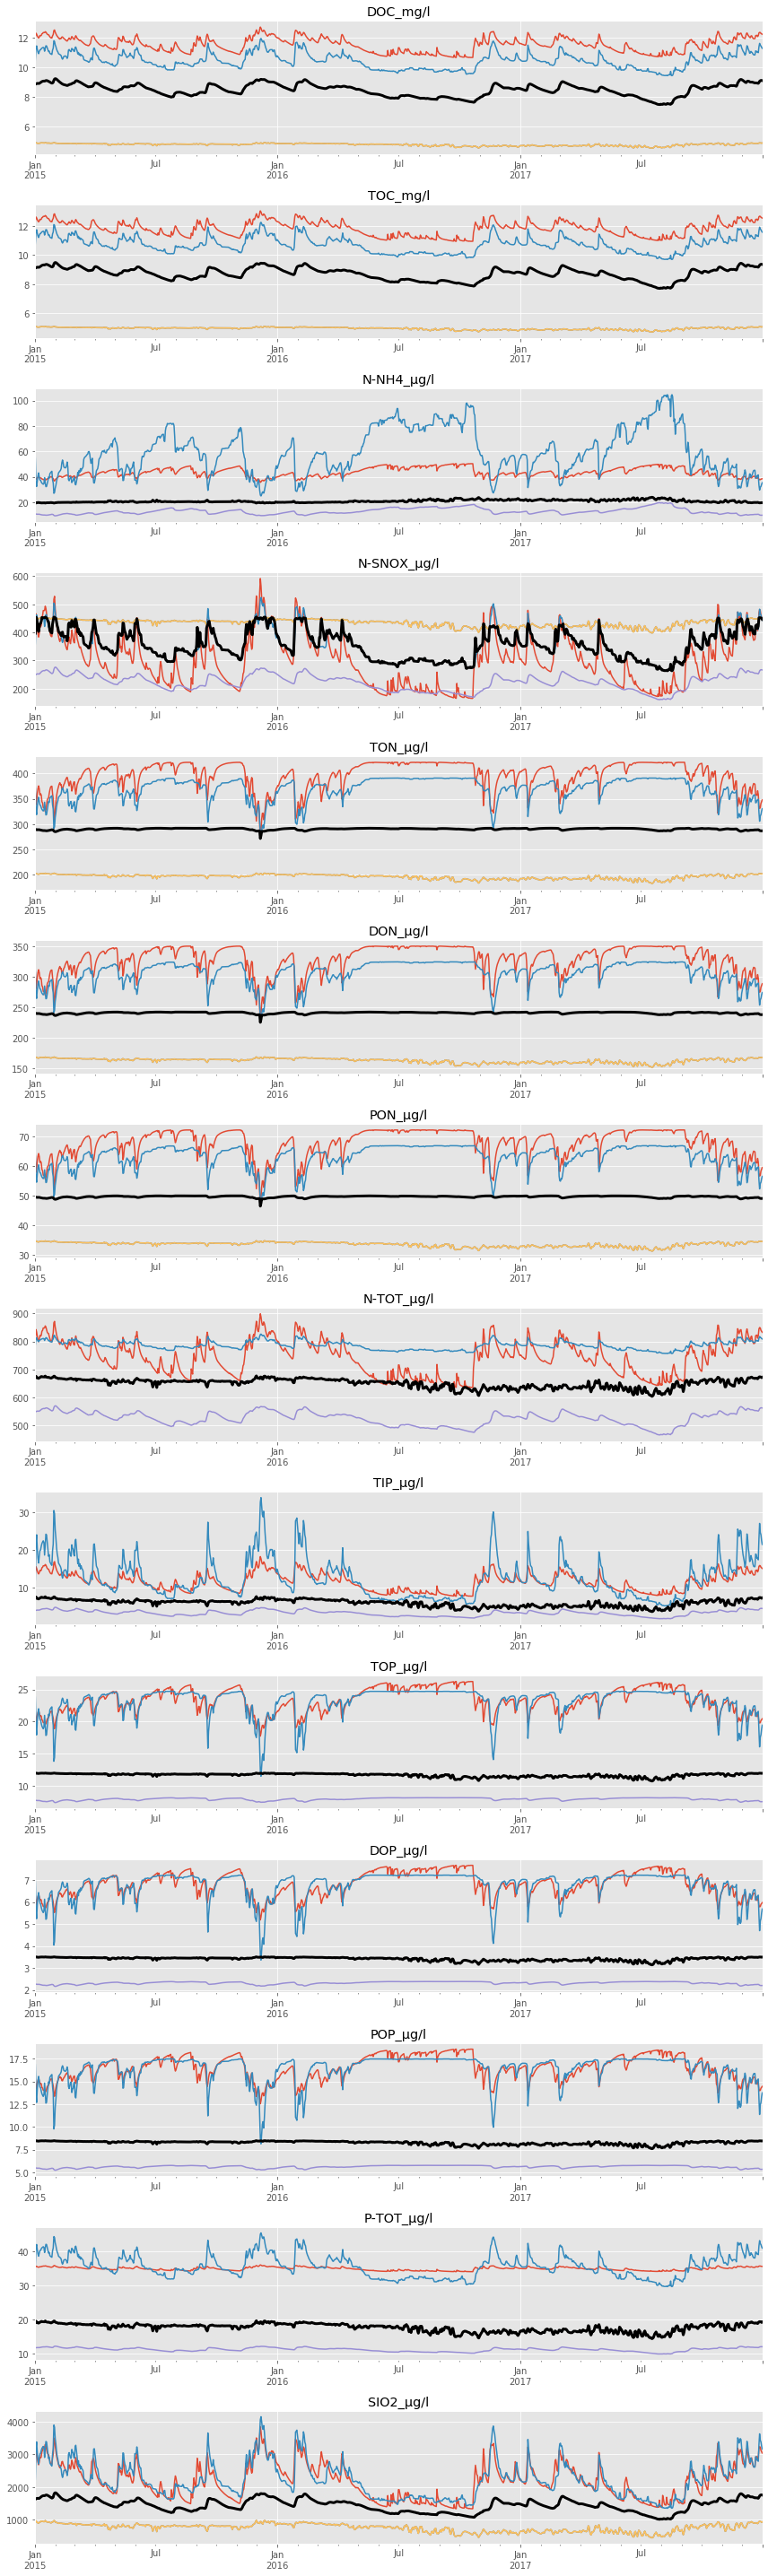

In [17]:
# Plot range of values for each variable
fig, axes = plt.subplots(nrows=len(swe_df['variable'].unique()), ncols=1, figsize=(12,40))

# Loop over Danish data
for idx, var_name in enumerate(swe_df['variable'].unique()):
    # Get data
    var_df = swe_df.query('variable == @var_name')
    
    # Loop over stations
    df_list = []
    for stn_id in var_df['station_id'].unique():
        # Get data for stn
        stn_var_df = var_df.query('station_id == @stn_id')
        stn_var_df = stn_var_df[['sample_date', 'value']]
        stn_var_df.set_index('sample_date', inplace=True)
        df_list.append(stn_var_df)
        stn_var_df.plot(ax=axes[idx], legend=False)
    
    # Get median over all stations for this variable
    agg_df = pd.concat(df_list, axis='columns')
    med_df = agg_df.median(axis='columns')
    patch_dict[('Sweden', var_name)] = med_df
    
    # Plot
    med_df.plot(ax=axes[idx], legend=False, lw=3, c='k')
    axes[idx].set_title(var_name)
    axes[idx].set_xlabel('')
    
plt.tight_layout()

In [18]:
# For consitency, adjust values for TON, N-TOT, TOP and P-TOT so that totals make sense
patch_dict[('Sweden', 'TON_µg/l')] = (patch_dict[('Sweden', 'DON_µg/l')] + 
                                       patch_dict[('Sweden', 'PON_µg/l')]) 

patch_dict[('Sweden', 'N-TOT_µg/l')] = (patch_dict[('Sweden', 'TON_µg/l')] + 
                                         patch_dict[('Sweden', 'N-NH4_µg/l')] + 
                                         patch_dict[('Sweden', 'N-SNOX_µg/l')])

patch_dict[('Sweden', 'TOP_µg/l')] = (patch_dict[('Sweden', 'DOP_µg/l')] + 
                                       patch_dict[('Sweden', 'POP_µg/l')])

patch_dict[('Sweden', 'P-TOT_µg/l')] = (patch_dict[('Sweden', 'TOP_µg/l')] + 
                                         patch_dict[('Sweden', 'TIP_µg/l')])

## 4. Patching

In [19]:
# Default values as medians from entire dataset where pathing at national level not possible
def_val_dict = {('Sweden', 'STS_mg/l')  : df['STS_mg/l'].median().round(0),
                ('Denmark', 'TOC_mg/l') : df['TOC_mg/l'].median().round(0),
                ('Denmark', 'DOC_mg/l') : df['DOC_mg/l'].median().round(0),
                ('Denmark', 'SIO2_µg/l'): df['SIO2_µg/l'].median().round(0),
               }

In [20]:
# Get list of Martini outflow locations
mar_stns = stn_df.dropna(subset=['andre_id']).drop_duplicates(subset=['andre_id'])
mar_stns

station_id andre_id                         station_name  country  \
0            NaN  dmca003                           Vigsø bukt  Denmark   
1    oda_4000005  dmca004  West side of Nord-Jylland - Liver Å  Denmark   
2    oda_3000002  dmca005         Hirtshals-Skagen - Uggerby Å  Denmark   
3            NaN  dmca006               Skagen- Lyngsaa strand  Denmark   
4            NaN  dmca007            East side of Nord-Jylland  Denmark   
5            NaN  dmca008                             Limfjord  Denmark   
6   oda_15000002  dmca009                          Kastbjerg A  Denmark   
8   oda_21000409  dmca010                             Alling A  Denmark   
9            NaN  dmca011                                 Læsø  Denmark   
14        vm_001  nmca001                     Haldenvassdraget   Norway   
15        vm_002  nmca002                               Glomma   Norway   
16        vm_003  nmca003                      Mossevassdraget   Norway   
17        vm_004  nmca004                            Hølenelva   Norway   
18        vm_005  nmca005                            Årungelva   Norway   
19        vm_006  nmca006                            Akerselva   Norway   
20        vm_007  nmca007                          Lysakerelva   Norway   
21        vm_008  nmca008                         Sandvikselva   Norway   
22        vm_009  nmca009                       Årosvassdraget   Norway   
23           NaN  nmca010                           Sageneelva   Norway   
24        vm_011  nmca011                             Lierelva   Norway   
25        vm_012  nmca012                         Drammenselva   Norway   
26        vm_013  nmca013                            Sandeelva   Norway   
27        vm_014  nmca014                       Aulivassdraget   Norway   
28        vm_015  nmca015                        Numedalslågen   Norway   
29        vm_016  nmca016                     Skiensvassdraget   Norway   
30        vm_017  nmca017                    Kragerøvassdraget   Norway   
31        vm_018  nmca018                    Vegårdsvassdraget   Norway   
32        vm_019  nmca019                   Arendalsvassdraget   Norway   
33        vm_020  nmca020                    Tovdalsvassdraget   Norway   
34        vm_021  nmca021                                 Otra   Norway   
35        vm_022  nmca022                          Mandalselva   Norway   
36        vm_023  nmca023                                Audna   Norway   
37        vm_024  nmca024                                Lygna   Norway   
38        vm_025  nmca025                                Kvina   Norway   
39   mvm_00043_n  smca108                       Göta Älv North   Sweden   
41     mvm_00031  smca109                               Bäveån   Sweden   
42     mvm_00032  smca110                         Örekilsälven   Sweden   
43     mvm_42954  smca111                             Strömsån   Sweden   
44     mvm_00035  smca112                      Enningdalsälven   Sweden   

                                         missing_vars             status  \
0                                                 All  No data available   
1                                      TOC, DOC, SiO2                NaN   
2                                      TOC, DOC, SiO2                NaN   
3                                                 All  No data available   
4                                                 All  No data available   
5                                                 All  No data available   
6                                      TOC, DOC, SiO2                NaN   
8                                      TOC, DOC, SiO2                NaN   
9                                                 All  No data available   
14                                                NaN                 OK   
15                                                NaN                 OK   
16  NH4, SNOX, TON, DON, PON, TIP, TOP, DOP, POP, ...       Limited data   
17  DOC, TOC, NH4

In [21]:
df_list = []

# All vars of interest, excluding flow
all_vars = [i for i in df_long['variable'].unique() if i != 'flow_m3/s']

# Loop over stations of interest
for idx, row in mar_stns.iterrows():
    mar_id = row['andre_id']
    stn_id = row['station_id']
    country = row['country']
    
    # Loop over vars
    for var_name in all_vars:
        # Do we have a complete datset based on measure data?
        stn_var_df = df_long.query('(station_id == @stn_id) and (variable == @var_name)').copy()
        
        if len(stn_var_df) == 0:
            # No data at all for this station
            stn_var_df = pd.DataFrame({'station_id': mar_id,
                                       'sample_date':pd.date_range('2015-01-01', '2017-12-31', freq='D'),
                                       'variable':var_name,
                                       'value':np.nan,
                                      })
        assert len(stn_var_df) == 1096
        
        if pd.isna(stn_var_df['value']).sum() == 0:
            # We have a complete data series
            # Change ID to mar_id
            stn_var_df['station_id'] = mar_id
            df_list.append(stn_var_df)
        else:
            # Do we have a series based on national median values?
            if (country, var_name) in patch_dict.keys():
                patch_df = patch_dict[(country, var_name)].reset_index()
                patch_df.columns = ['sample_date', 'value']
                patch_df['variable'] = var_name
                patch_df['station_id'] = mar_id
                df_list.append(patch_df)
            else:
                # Use a constant default value
                stn_var_df['value'] = def_val_dict[(country, var_name)]
                
                # Change ID to mar_id
                stn_var_df['station_id'] = mar_id
                df_list.append(stn_var_df)

# Combine and reshape
patched_df = pd.concat(df_list, axis='rows', sort=True)
patched_df.set_index(['station_id', 'sample_date', 'variable'], inplace=True)
patched_df = patched_df.unstack('variable')
patched_df.reset_index(inplace=True)
patched_df.columns = (list(patched_df.columns.get_level_values(0)[:2]) + 
                      list(patched_df.columns.get_level_values(1)[2:]))

# Reorder cols
cols = list(df.columns)
cols.remove('flow_m3/s')
patched_df = patched_df[cols]

# Save
out_csv = r'../data/tidy/martini_daily_concs_patched.csv'
patched_df.to_csv(out_csv, index=False, encoding='utf-8')

patched_df.head()

station_id sample_date  DOC_mg/l  TOC_mg/l  N-NH4_µg/l  N-SNOX_µg/l  \
0    dmca003  2015-01-01       5.0       5.0  244.304822  4645.714425   
1    dmca003  2015-01-02       5.0       5.0  261.189719  4688.556342   
2    dmca003  2015-01-03       5.0       5.0  258.166702  4836.287039   
3    dmca003  2015-01-04       5.0       5.0  242.095014  4794.811124   
4    dmca003  2015-01-05       5.0       5.0  227.883526  4612.156997   

     TON_µg/l    DON_µg/l    PON_µg/l   N-TOT_µg/l   TIP_µg/l    TOP_µg/l  \
0  742.741207  615.619586  127.121621  5632.760454  63.014582  104.977148   
1  768.583947  637.039290  131.544657  5718.330008  60.951613  110.171391   
2  771.913654  639.799111  132.114543  5866.367395  62.104700  110.224152   
3  744.067947  616.719252  127.348695  5780.974086  65.408950  106.164337   
4  791.553738  656.077756  135.475982  5631.594261  67.016363  107.052018   

    DOP_µg/l   POP_µg/l  P-TOT_µg/l  SIO2_µg/l   STS_mg/l  
0  30.695346  74.281803  167.991730     1149.0  22.823943  
1  32.214143  77.957247  171.123003     1149.0  26.953047  
2  32.229571  77.994581  172.328852     1149.0  26.997606  
3  31.042480  75.121857  171.573287     1149.0  22.000050  
4  31.302038  75.749980  174.068382     1149.0  24.413134